In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobilities, _ = load_od_mobilities()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

/Users/Ronan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [3]:
N_DAYS = 28
ONSET_THRESH = 3
GROWTH_THRESH = 0

In [4]:
## Get death dataframe date columns
death_dates = get_date_columns(deaths, return_dtimes=False)

## Moving average (weekly) mobility
od_mobilities_ma = od_mobilities.copy()
od_mobilities_ma[od_mobilities_ma.columns[1:]] = od_mobilities[od_mobilities.columns[1:]].rolling(7, center=True, axis=1).mean()
od_mobilities_ma = od_mobilities_ma.dropna(axis=1)

In [5]:
def get_onset_date(row, thresh):
    above = row[row >= thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [6]:
deaths_df = deaths[['FIPS']+death_dates]
deaths_df.dropna(subset=['FIPS'], inplace=True)
deaths_df = deaths_df.astype({'FIPS':int})

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row, thresh=ONSET_THRESH), axis=1)

## Drop counties with no onset
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

## Only counties with N_DAYS worth of data after onset
deaths_df = deaths_df[deaths_df['onset'].apply(
    lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= N_DAYS
)]

## Remove counties with growth decrease
deaths_df = deaths_df[
    deaths_df.apply(
        lambda r: r[[d for d in death_dates if 
            str2date(d) >= str2date(r['onset']) and 
            str2date(d) <= lag_date(str2date(r['onset']
        ), 
        lag=N_DAYS, backwards=False)
                    ]].diff().min() >= GROWTH_THRESH, axis=1
    )
]

## Get the number of deaths at N_DAYS from onset
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: r[lag_date(str2date(r['onset']), lag=N_DAYS, backwards=False, return_date=False)], axis=1
)

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths', 'onset']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

## OD baseline
od_dates = get_date_columns(od_mobilities, return_dtimes=False)
od_mobilities['OD_baseline'] = od_mobilities.apply(lambda x: x[od_dates[:14]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, od_mobilities[['FIPS', 'OD_baseline']], on='FIPS')

## OD at onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][row['onset']].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_at_onset'] = new_row

## OD 2 weeks before onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        lag_onset = lag_date(row['onset'], lag=14, backwards=True, return_date=False)
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][lag_onset].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_2wk_before_onset'] = new_row

## OD 2 weeks after onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        lag_onset = lag_date(row['onset'], lag=14, backwards=False, return_date=False)
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][lag_onset].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_2wk_after_onset'] = new_row

## static features
static_features = counties[
    ['FIPS',
     'Rural-urban_Continuum Code_2013',
     'Density per square mile of land area - Population',
     'Percent of adults with less than a high school diploma 2014-18',
     'PCTPOV017_2018',
     'Unemployment_rate_2018',
     'Total_age65plus', 
     'POP_ESTIMATE_2018']
]
static_features = static_features.dropna()
cum_deaths = cum_deaths.merge(static_features, on="FIPS")

## normalize
cum_deaths['cum_deaths_normalized'] = cum_deaths.apply(
     lambda row: row['cum_deaths'] / row['POP_ESTIMATE_2018'], axis=1
     )
cum_deaths['OD_baseline_normalized'] = cum_deaths.apply(
     lambda row: row['OD_baseline'] / row['POP_ESTIMATE_2018'], axis=1
     )
cum_deaths['OD_at_onset_normalized'] = cum_deaths.apply(
     lambda row: row['OD_at_onset'] / row['OD_baseline_normalized'], axis=1
     )
cum_deaths['OD_2wk_before_onset_normalized'] = cum_deaths.apply(
     lambda row: row['OD_2wk_before_onset'] / row['OD_baseline_normalized'], axis=1
     )
cum_deaths['OD_2wk_after_onset_normalized'] = cum_deaths.apply(
     lambda row: row['OD_2wk_after_onset'] / row['OD_baseline_normalized'], axis=1
     )

In [15]:
outliers = [36061, 6038, 17031, 48201]
cum_deaths = cum_deaths[~cum_deaths['FIPS'].isin(outliers)]

In [16]:
log_cols = ['cum_deaths',
            'cum_deaths_normalized',
            'OD_baseline_normalized',
            'Density per square mile of land area - Population',
            'POP_ESTIMATE_2018',
            'OD_2wk_before_onset_normalized',
            'OD_at_onset_normalized',
            'OD_2wk_after_onset_normalized',
           ]
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')

/Users/Ronan/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [18]:
cluster_cols = [
    'Rural-urban_Continuum Code_2013',
    'cum_deaths_normalized (log)',
    'Density per square mile of land area - Population',
    'POP_ESTIMATE_2018',
    'OD_baseline_normalized',
    'OD_2wk_before_onset_normalized',
    'OD_at_onset_normalized',
    'OD_2wk_after_onset_normalized',
]

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [27]:
X = cum_deaths[cluster_cols].values

In [29]:
pca = PCA(n_components=8)
Xhat = pca.fit_transform(X)

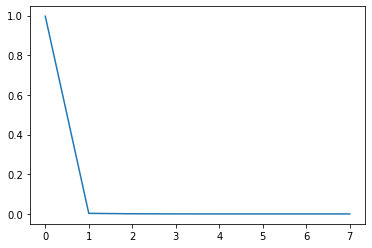

In [30]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [36]:
n_clusters = np.arange(2,12,1)
for n_clusters in n_clusters:
    clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(Xhat[:,:2])
    score = silhouette_score(Xhat[:,:2], clustering.labels_)
    print(f'{n_clusters}: {score}')

2: 0.8598260805167743
3: 0.8259029540521285
4: 0.728039900256984
5: 0.6477737771007741
6: 0.6404362570552374
7: 0.648897380773698
8: 0.5799288079616806
9: 0.5796386402725785
10: 0.5727795577146702
11: 0.574712368369144


In [37]:
clustering = KMeans(n_clusters=2, random_state=0).fit(Xhat[:,:2])

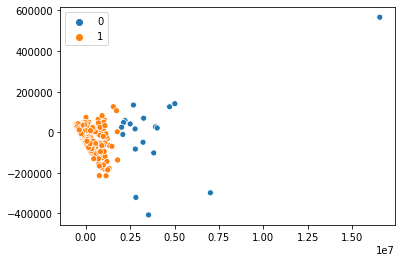

In [42]:
sns.scatterplot(Xhat[:,0], Xhat[:,1], hue=clustering.labels_)